In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.devices.experimental import TestDevicePythonSim, TestDeviceMPSSim
from pennylane.devices.experimental import PlainNumpySimulator, NumpyMPSSimulator

import matplotlib.pyplot as plt
from time import time

# Simulator execution

In [2]:
sim = NumpyMPSSimulator()
check_sim = PlainNumpySimulator()
ops = [qml.Hadamard(0) @ qml.PauliX(1)]
meas = [qml.expval(qml.PauliX(0))]
qs = qml.tape.QuantumScript(ops=ops, measurements=meas)

In [3]:
sim.execute(qs), check_sim.execute(qs)

bond dimension = 1


(array(1.), 0.9999999999999996)

# Device

In [4]:
dev = TestDeviceMPSSim()
dev_check = TestDevicePythonSim()

In [5]:
a = [0.1, 0.2, 0.3]
ops = [qml.RX(a[0], wires=0),
    qml.CNOT(wires=(0,1)),
    qml.RY(a[1], wires=1),
    qml.RZ(a[2], wires=1)]
measurement = qml.expval(qml.PauliX(0) @ qml.PauliX(1))
qs = qml.tape.QuantumScript(ops, [measurement])

dev.execute(qs), dev_check.execute(qs)

bond dimension = 2


(array(0.02950279), 0.02950279191917826)

# Benchmark

## Compare with full state vector simulator

In [6]:
def mps2vec(state):
    """
    Transform an MPS state into a full vector

    Used for comparing results with full state vector simulations
    """
    Bs = state.Bs
    vec = Bs[0]
    for i in range(1, state.L):
        vec = np.tensordot(vec, Bs[i], 1)
    return vec.reshape(-1)

In [7]:
times = []
times2 = []
fids = []

depth = 10
chi_maxs = [50, 75, 100, 150, 200]
n_wiress = np.arange(5, 25, 1)

for n_wires in n_wiress:
    a = 2*np.pi*np.random.rand(*(depth, 2*n_wires))
    ops = [qml.Hadamard(i) for i in range(n_wires)]
    for k in range(depth):
        ops += [qml.RY(a[k, i], wires=i) for i in range(n_wires)]
        ops += [qml.RX(a[k, i+n_wires], wires=i) for i in range(n_wires)]
        ops += [qml.CNOT((i, i+1)) for i in range(n_wires-1)]

    measurement = [qml.state()]

    qs = qml.tape.QuantumScript(ops, measurement)

    t0 = time()
    res_check = dev_check.execute(qs)
    dt2 = time()-t0
    times2.append(dt2)

    for chi_max in chi_maxs:
        t0 = time()
        res = dev.execute(qs, chi_max=chi_max)
        dt = time()-t0
        times.append(dt)

        vec = mps2vec(res)
        fidelity = np.abs(vec.conj().T @ res_check)
        fids.append(fidelity)

        print(f"n_wires = {n_wires}, depth = {depth}, chi = {chi_max}, exec time mps: {dt:.5f}, full state {dt2:.5f}")

        if not qml.math.allclose(fidelity, 1):
            print(f"results dont match: F = {fidelity}")

bond dimension = 4
n_wires = 5, depth = 10, chi = 50, exec time mps: 0.04217, full state 0.02000
bond dimension = 4
n_wires = 5, depth = 10, chi = 75, exec time mps: 0.04188, full state 0.02000
bond dimension = 4
n_wires = 5, depth = 10, chi = 100, exec time mps: 0.03650, full state 0.02000
bond dimension = 4
n_wires = 5, depth = 10, chi = 150, exec time mps: 0.03650, full state 0.02000
bond dimension = 4
n_wires = 5, depth = 10, chi = 200, exec time mps: 0.03952, full state 0.02000
bond dimension = 8
n_wires = 6, depth = 10, chi = 50, exec time mps: 0.05578, full state 0.02039
bond dimension = 8
n_wires = 6, depth = 10, chi = 75, exec time mps: 0.05117, full state 0.02039
bond dimension = 8
n_wires = 6, depth = 10, chi = 100, exec time mps: 0.04885, full state 0.02039
bond dimension = 8
n_wires = 6, depth = 10, chi = 150, exec time mps: 0.04750, full state 0.02039
bond dimension = 8
n_wires = 6, depth = 10, chi = 200, exec time mps: 0.04422, full state 0.02039
bond dimension = 8
n_wir

/home/qottmann/Qottmann/Xanadu/pennylane/pennylane/devices/experimental/custom_device_3_numpydev/python_mps.py:265: UserWarning: SVD with lapack_driver 'gesdd' failed. Use backup 'gesvd'
  X, Y, Z = svd(theta, full_matrices=False) #TODO switch to qml.math.svd


bond dimension = 100
n_wires = 23, depth = 10, chi = 100, exec time mps: 6.76904, full state 65.99446
results dont match: F = 0.9832722210372441
bond dimension = 150
n_wires = 23, depth = 10, chi = 150, exec time mps: 9.71389, full state 65.99446
results dont match: F = 0.99898444962721
bond dimension = 200
n_wires = 23, depth = 10, chi = 200, exec time mps: 17.29920, full state 65.99446
results dont match: F = 0.9999370036980164
bond dimension = 50
n_wires = 24, depth = 10, chi = 50, exec time mps: 10.19700, full state 136.73640
results dont match: F = 0.7276405216995021
bond dimension = 75
n_wires = 24, depth = 10, chi = 75, exec time mps: 7.06116, full state 136.73640
results dont match: F = 0.9432837446046985
bond dimension = 100
n_wires = 24, depth = 10, chi = 100, exec time mps: 11.36394, full state 136.73640
results dont match: F = 0.9894069874255341
bond dimension = 150
n_wires = 24, depth = 10, chi = 150, exec time mps: 10.01078, full state 136.73640
results dont match: F = 0.

In [8]:
times = np.reshape(times, (len(n_wiress), len(chi_maxs)))
fids = np.reshape(fids, (len(n_wiress), len(chi_maxs)))

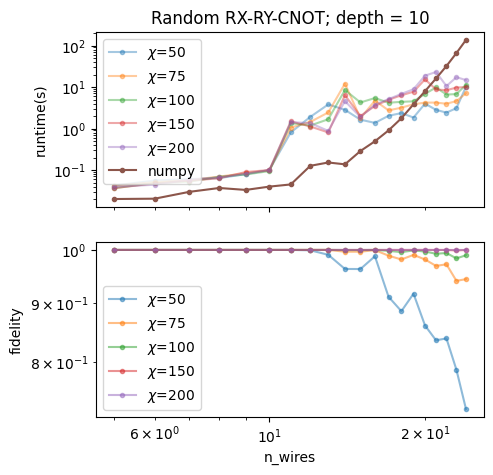

In [14]:
fig, axs = plt.subplots(nrows=2, figsize=(5,5), sharex=True)

ax = axs[0]
for i, chi_max in enumerate(chi_maxs):
    ax.plot(n_wiress, times[:, i], ".-", label=f"$\\chi$={chi_max}", alpha=0.4)
ax.plot(n_wiress, times2, ".-", label="numpy")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("runtime(s)")
ax.legend()
ax.set_title(f"Random RX-RY-CNOT; depth = {depth}")

ax2 = axs[1]
for i, chi_max in enumerate(chi_maxs):
    ax2.plot(n_wiress, fids[:, i], ".-", label=f"$\\chi$={chi_max}", alpha=0.5)
ax2.set_yscale("log")
ax2.set_ylabel("fidelity")
ax2.legend()
ax2.set_xlabel("n_wires")

plt.savefig("mps-vs-full.png", bbox_inches = 'tight', dpi=500)

## Finite size scaling
For <30 qubits we can compare with exact state vector methods to deduce the fidelity. The point of this mps simulator is not to compete with full state vector simulators like lightning, but rather to be able to simulate systems otherwise intractible.

**But when simulating, say, 50 qubits, how do we know if our simulations are faithful?**

One answer is, as always, finite size scaling. Meaning in this case that we run the simulation for different bond dimensions and check whether or not the results have converged.

In the following we simulate the same random 50 qubit circuit for increasing bond dimensions. If the result converges to a fix value, it is a good indicator that the simulation is faithful. This is pure heuristics though, but works well in practice.

Matrix product states offer more advanced means to quantify the faithfullness of the approximation. I.e. the cut-off at each compression when a gate is applied is a direct measure for the approximation error. I have not yet found a nice way to output this from the qnode, though it is no problem in principle.

In [16]:
times = []
ress = []
depths = [5, 7, 9, 11, 13]

for depth in depths:
    n_wires = 50
    chi_maxs = [50, 75, 100, 150, 200]

    np.random.seed(12345)
    a = 2*np.pi*np.random.rand(*(depth, 2*n_wires))
    ops = [qml.Hadamard(i) for i in range(n_wires)]
    for k in range(depth):
        ops += [qml.RY(a[k, i], wires=i) for i in range(n_wires)]
        ops += [qml.RX(a[k, i+n_wires], wires=i) for i in range(n_wires)]
        ops += [qml.CNOT((i, i+1)) for i in range(n_wires-1)]

    measurement = []
    for i in range(n_wires-1):
        measurement.append(qml.expval(qml.PauliX(i) @ qml.PauliX(i+1)))

    for chi_max in chi_maxs:
        qs = qml.tape.QuantumScript(ops, measurement)
        t0 = time()
        res = np.sum(dev.execute(qs, chi_max=chi_max))
        dt = time()-t0

        print(f"chi_max = {chi_max}, res = {res}, exec time mps: {dt:.5f}")

        times.append(dt)
        ress.append(res)

bond dimension = 32
chi_max = 50, res = -0.059808830806669544, exec time mps: 0.97693
bond dimension = 32
chi_max = 75, res = -0.059808830806669544, exec time mps: 0.43688
bond dimension = 32
chi_max = 100, res = -0.059808830806669544, exec time mps: 0.36896
bond dimension = 32
chi_max = 150, res = -0.059808830806669544, exec time mps: 0.40559
bond dimension = 32
chi_max = 200, res = -0.059808830806669544, exec time mps: 0.46549
bond dimension = 50
chi_max = 50, res = 0.04784924210843616, exec time mps: 3.98603
bond dimension = 75
chi_max = 75, res = 0.047987125520960724, exec time mps: 5.51488
bond dimension = 100
chi_max = 100, res = 0.047986288844167835, exec time mps: 3.55655
bond dimension = 128
chi_max = 150, res = 0.04798628513626753, exec time mps: 4.87435
bond dimension = 128
chi_max = 200, res = 0.04798628513626753, exec time mps: 4.50795
bond dimension = 50
chi_max = 50, res = 0.04023262960678649, exec time mps: 8.85044
bond dimension = 75
chi_max = 75, res = 0.0450941121780

In [17]:
times = np.reshape(times, (len(depths), len(chi_maxs)))
ress = np.reshape(ress, (len(depths), len(chi_maxs)))

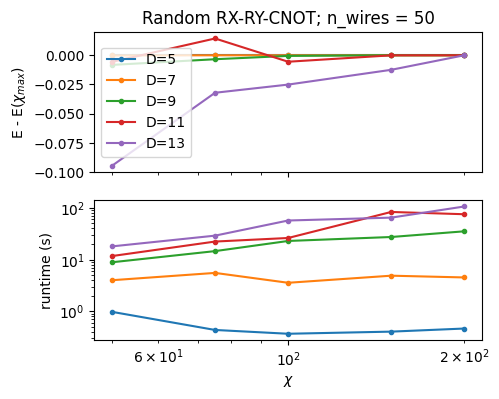

In [22]:
fig, axs = plt.subplots(nrows=2, figsize=(5,4), sharex=True)

ax = axs[0]
ax.set_title(f"Random RX-RY-CNOT; n_wires = {n_wires}")
for i, depth in enumerate(depths):
    ax.plot(chi_maxs, ress[i]-ress[i,-1], ".-", label=f"D={depth}")
ax.legend()
#ax.set_yscale("log")

ax.set_ylabel("E - E($\\chi_{{max}}$)")

ax2 = axs[1]
for i, depth in enumerate(depths):
    ax2.plot(chi_maxs, times[i], ".-", label=f"depth={depth}")
ax.legend(loc=6)
ax2.set_yscale("log")
ax2.set_ylabel("runtime (s)")
ax2.set_xlabel("$\\chi$")
ax2.set_xscale("log")

plt.savefig("mps-finite-size-scaling.png", bbox_inches = 'tight', dpi=500)

All but the $D=13$ runs seem to have converged to a reasonable value. Note that because the parameters are random for every depth, the resulting energies are very different and hence I plot $E(\chi) - E(\chi_\text{max})$.

# Gradient
needs overlap function for adjoint method

In [ ]:
chi_max=20; eps=1e-10
ops = [qml.RY(0.5, wires=0), qml.Identity(1)]
measurement = qml.expval(qml.PauliX(0))
qscript = qml.tape.QuantumScript(ops, [measurement])

In [ ]:
dev.execute(qscript), dev_check.execute(qscript)

(array(0.47942554), 0.47942553860420284)

In [ ]:
dev.gradient(qscript), dev_check.gradient(qscript)

([array(0.87758256)], [0.8775825618903725])

In [ ]:
a = [0.1, 0.2, 0.3]
ops = [qml.RY(a[0], wires=0),
    qml.CNOT(wires=(0,1)),
    qml.RY(a[1], wires=1),
    qml.RZ(a[2], wires=1)]
measurement = qml.expval(qml.PauliX(0) @ qml.PauliX(1))
qs = qml.tape.QuantumScript(ops, [measurement])

dev.execute(qs), dev_check.execute(qs)

(array(0.09347337), 0.09347336547036136)

In [ ]:
dev.gradient(qs), dev_check.gradient(qs)

([array(0.9316158), array(-0.01894799), array(8.67361738e-19)],
 [0.9316157966884513, -0.018947989233612104, -0.028914700312991287])

Gradients are still a bit buggy, my main suspicion is that using ``apply_operation`` to apply the observable and ``dU=iGU`` in ``TestDeviceMPSSim.gradient`` is not correct. For Pauli gates they are in principle unitaries, however, the ``qml.operations.operation_derivative`` accesses the generator which is defined as ``0.5 * Pauli`` in pennylane.